## Tahap 2: Pemodelan & Evaluasi Posisi Pemain
Tujuan: untuk memuat data yang sudah bersih, melatih model klasifikasi, melakukan optimasi dengan hyperparameter tuning, dan mengevaluasi serta memvisualisasikan hasilnya.


Metode:
- Melatih model Decision Tree dengan parameter default sebagai baseline.
- Mencari parameter terbaik menggunakan GridSearchCV.
- Melatih model final dengan parameter terbaik.
- Membandingkan performa kedua model secara numerik dan visual.

#### 2.1. Impor Library dan Muat Data

In [ ]:
# Mengimpor library yang dibutuhkan
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

In [ ]:
# Memuat hasil data dari file pre-processing
df_model = pd.read_csv('D:\soccer_position\data\process\clean_data.csv')

#### 2.2. Persiapan Data untuk Pemodelan

In [ ]:
# Pisahkan fitur (X) dan target (y)
columns_to_drop = ['short_name', 'player_positions', 'simple_position']
X = df_model.drop(columns=columns_to_drop)
y = df_model['simple_position']

# Normalisasi menggunakan min max scaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data untuk train dan test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=27, stratify=y)

#### 2.3. Analisis Model Default (Baseline)

In [163]:
# Training default data
default = DecisionTreeClassifier()
default.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
# Test data
y_pred_default = default.predict(X_test)

# Evaluasi data
print("\n===== Hasil Evaluasi Model Daefault =====\n")
print(confusion_matrix(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default))

#### 2.4. Optimasi Model dengan GridSearchCV


In [164]:
# Pengaturan
# Ubah menjadi True jikan ingin menjalankan ulang pencarian grid search
# Ubah menjadi False jika tidak ingin melakukan pencarian dan telah menetapkan nilai parameter ternaik

do_search = False

if do_search:
    # Hyperparameter tuning
    param_grid = {
        'max_depth': [5, 10, 15, 20],
        'min_samples_split':[20, 50, 100],
        'min_samples_leaf':[10, 20, 40]
    }

    grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                            param_grid=param_grid,
                            cv=5,
                            n_jobs=-1, # Gunakan semua core CPU agar lebih cepat
                            verbose=2)
    
    # Memulai proses pencarian (Need a little bit of time TT )
    grid_search.fit(X_train, y_train)

    # Menyimpan parameter terbaik
    best_params = grid_search.best_params_

else:
    # Tulis parameter terbaik disini
    best_params = {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20}


#### 2.5. Evaluasi dan Analisis Model Terbaik (Hasil Tuning)

In [165]:
# Training model tuning dengan parameter terbaik
tuning = DecisionTreeClassifier(**best_params)
tuning.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [166]:
# Uji prediksi model tuning
y_pred_tuning = tuning.predict(X_test)

# Evaluasi model
print(confusion_matrix(y_test, y_pred_tuning))
print(classification_report(y_test, y_pred_tuning))

[[1155  124    0]
 [ 113 1179  115]
 [   3  174  559]]
              precision    recall  f1-score   support

         Bek       0.91      0.90      0.91      1279
   Gelandang       0.80      0.84      0.82      1407
   Penyerang       0.83      0.76      0.79       736

    accuracy                           0.85      3422
   macro avg       0.85      0.83      0.84      3422
weighted avg       0.85      0.85      0.85      3422



#### 2.6. Visualisasi Model Terbaik (Tuning)

----- 15 Fitur Paling Penting Menurut Model Terbaik -----


,feature,importance
0,defending_sliding_tackle,0.325225
1,mentality_vision,0.232694
2,attacking_heading_accuracy,0.123572
3,skill_long_passing,0.070829
4,attacking_crossing,0.049467
5,attacking_finishing,0.035797
6,overall,0.035055
7,attacking_short_passing,0.023659
8,movement_sprint_speed,0.013976
9,defending_marking_awareness,0.013138


C:\Users\faust\AppData\Local\Temp\ipykernel_14948\2508472613.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance',


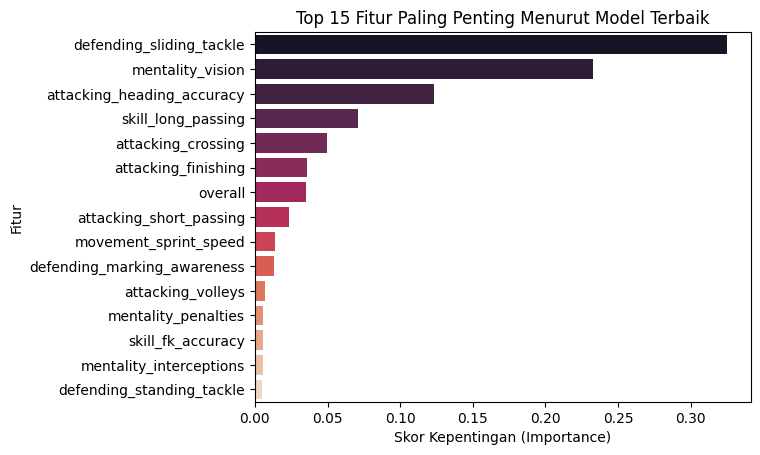

In [ ]:
# Membuat visualisasi fitur yang digunakan untuk membedakan posisi pemain
# Mengambil nama fitur pada kolom X
feature_names = X.columns

# Mendapatkan nilai kepentingan pada fitur di model tuning
importances = tuning.feature_importances_

# Membuat DataFrame untuk menggabungkan nama fitur dan nilainya
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

# --- Visualisasi ---
print("----- 15 Fitur Paling Penting Menurut Model Terbaik -----")
display(feature_importance_df.head(15).sort_values(by='importance', ascending=False))

sns.barplot(x='importance', 
            y='feature', 
            data=feature_importance_df.head(15), 
            palette='rocket')

plt.title('Top 15 Fitur Paling Penting Menurut Model Terbaik')
plt.xlabel('Skor Kepentingan (Importance)')
plt.ylabel('Fitur')
plt.show()

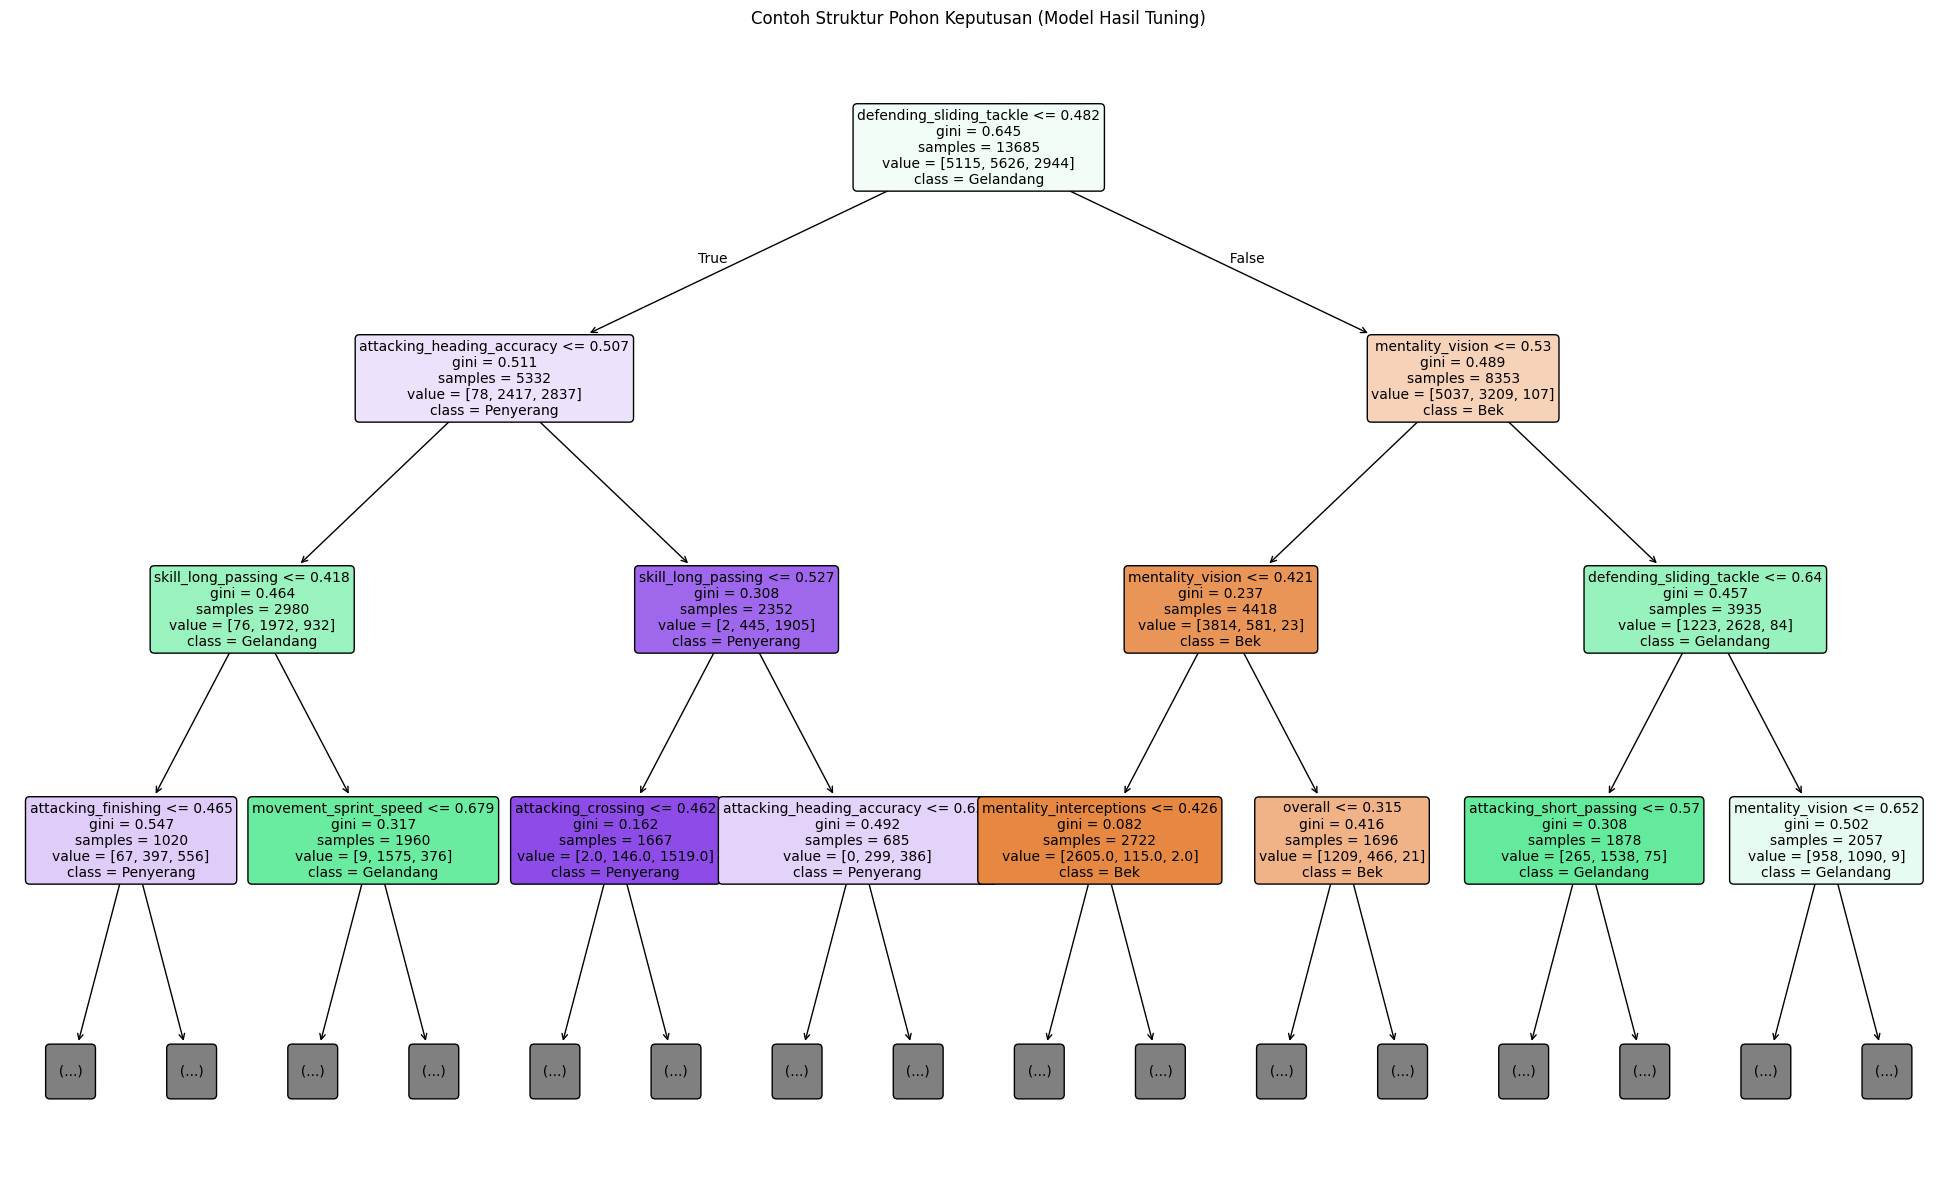

In [ ]:
# Membuat gambaran contoh decision tree pada model terbaik (tuning)
plt.figure(figsize=(25, 15))
tree.plot_tree(tuning,
               feature_names=feature_names,
               class_names=tuning.classes_, # Ambil urutan kelas dari model
               filled=True,
               rounded=True,
               max_depth=3,
               fontsize=10)

plt.title("Contoh Struktur Pohon Keputusan (Model Hasil Tuning)")
plt.show()

#### 2.7. Visualisasi Perbandingan Kinerja Model

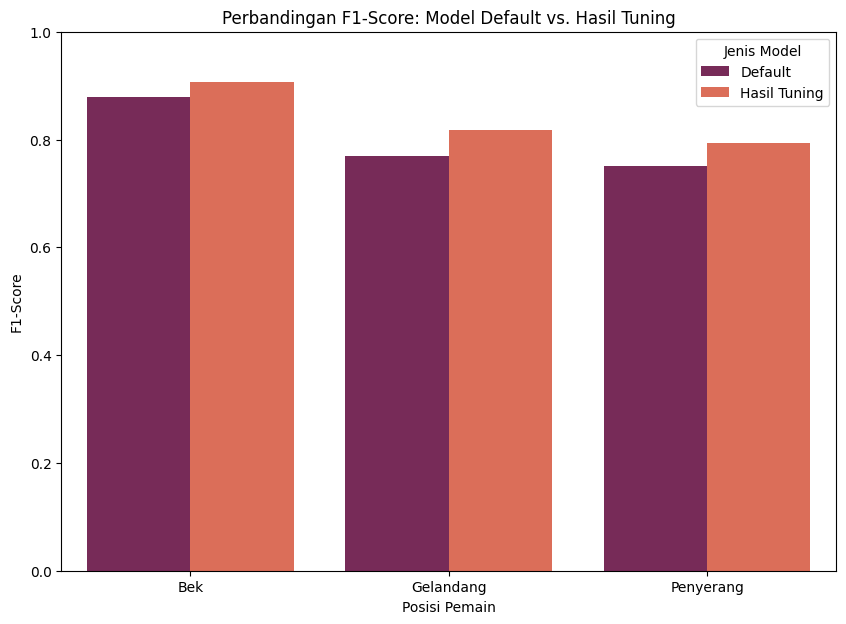

In [171]:
# Grafik Perbandingan F1-Score
# Dapatkan classification report sebagai dictionary agar mudah diolah
report_default = classification_report(y_test, y_pred_default, output_dict=True)
report_terbaik = classification_report(y_test, y_pred_tuning, output_dict=True)

# Siapkan data untuk diplot
posisi = ['Bek', 'Gelandang', 'Penyerang']
f1_default = [report_default[p]['f1-score'] for p in posisi]
f1_terbaik = [report_terbaik[p]['f1-score'] for p in posisi]

# Buat DataFrame untuk perbandingan
df_compare = pd.DataFrame({
    'Posisi': posisi * 2,
    'F1-Score': f1_default + f1_terbaik,
    'Model': ['Default'] * len(posisi) + ['Hasil Tuning'] * len(posisi)
})

# Buat visualisasi bar chart perbandingan
plt.figure(figsize=(10, 7))
sns.barplot(x='Posisi', y='F1-Score', hue='Model', data=df_compare, palette='rocket')

plt.title('Perbandingan F1-Score: Model Default vs. Hasil Tuning')
plt.ylabel('F1-Score')
plt.xlabel('Posisi Pemain')
plt.ylim(0, 1.0) # Atur limit sumbu Y dari 0 sampai 1
plt.legend(title='Jenis Model')
plt.show()

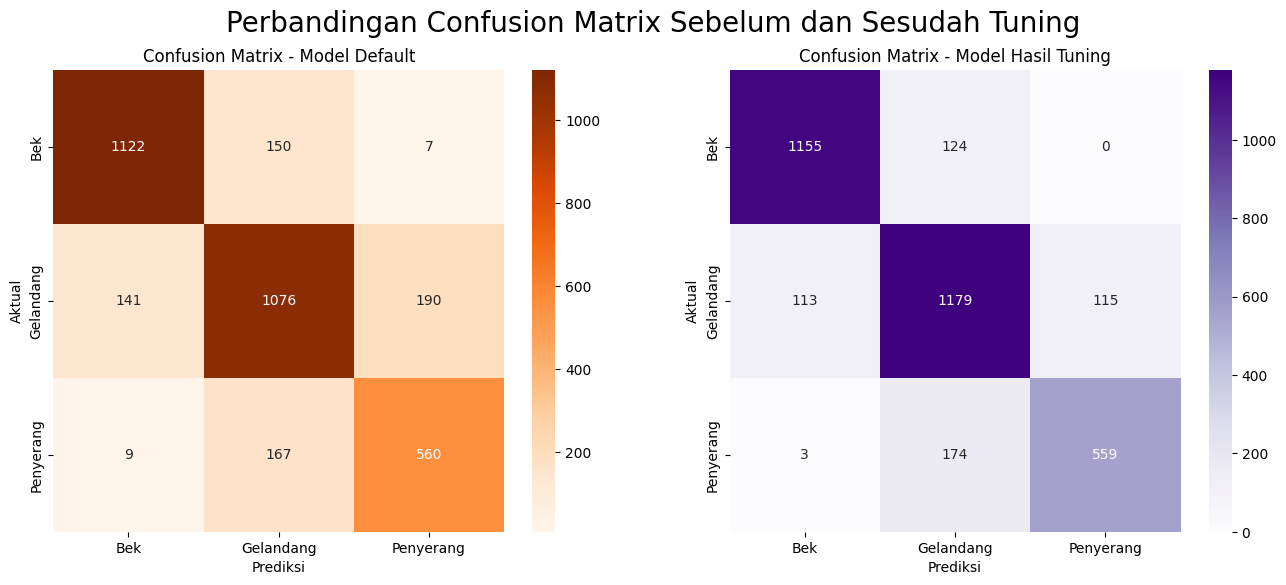

In [177]:
# Grafik Perbandingan Confusion Matrix

# Matriks dari kedua model
cm_default = confusion_matrix(y_test, y_pred_default, labels=default.classes_)
cm_terbaik = confusion_matrix(y_test, y_pred_tuning, labels=tuning.classes_)

# Area plot untuk 2 grafik berdampingan
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # 1 baris, 2 kolom

# Plot untuk model default
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=default.classes_, yticklabels=default.classes_)
axes[0].set_title('Confusion Matrix - Model Default')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Aktual')

# Plot untuk model terbaik (Hasil Tuning)
sns.heatmap(cm_terbaik, annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=tuning.classes_, yticklabels=tuning.classes_)
axes[1].set_title('Confusion Matrix - Model Hasil Tuning')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Aktual')

# Judul utama untuk keseluruhan gambar
plt.suptitle('Perbandingan Confusion Matrix Sebelum dan Sesudah Tuning', fontsize=20)
plt.show()